# 5.0 Model Inference

## What is Model Inference? The Best Part!
Plainly, model inference is using a trained model to make predictions on new data.  

Practically, model inference is the step that is likely most important and interesting to those working in clinical drug development.  

This is when we use our best performing trained ADMET model to predict the activity on a set of new compounds.  

## Using ADMET models in Real World Drug Development
In this CYP3A4 example, let's say that we are interested in screening for compounds that inhibit CYP3A4 because we want to remove them from our pool of leads.  

In this scenario, our pool of leads is >100,000 theoretical compounds. These compounds have not yet been synthesized for lab testing and it would be too resource intensive to synthesize and empirically measure CYP inhibition behaviour of all of them.  

This is where the utility of ADMET models really shines.  

Before even stepping into the lab and solely with the SMILES strings of the 100k+ compounds, we can use our trained ADMET model as a screening tool to narrow down pool to only the most promising leads.  

After having trained a couple of models on ChEMBL CYP3A4 data and compared their performances, we've now picked our best performing model: the ensemble LGBM model.  

We can now predict the inhibition activity of our pool of lead compounds. In this demo notebook, we've sampled a small subset of compounds from the [Enamine Diversity](https://enamine.net/compound-libraries/diversity-libraries/dds-10240) & [FDA-Approved Drug](https://enamine.net/compound-libraries/bioactive-libraries/fda-approved-drugs-collection) decks to serve as the compounds we're interested in screening. This combines a deck with diverse lead-like chemistry and some existing approved drugs we may want to repurpose. 

### Requirements
For this demo, you will need:
1. A model trained in anvil
2. A dataset of compounds unseen by the model. The dataset must contain a column of SMILES strings.

## [OPTIONAL] Data Cleaning
You may want to do some data cleaning prior to model prediction, i.e. standardizing the SMILES strings and dropping any duplicates. We have done that already with `discovery_compounds.csv`.

## Use Anvil to predict on the new set of compounds
As with training models with Anvil, doing model inference is also a simple command with the following arguments:
```bash
    openadmet predict \
        --input-path <the path to the data to predict on> \
        --input-col <the column to of the data to predict on, often SMILES> \
        --model-dir <the anvil_training directory of the model to predict with> \
        --output-csv <the path to an output CSV to save the predictions to> \
        --accelerator <whether to use gpu or cpu, defaults to gpu>
```

In [1]:
%%bash
export OADMET_NO_RICH_LOGGING=1

openadmet predict \
    --input-path discovery_compounds.csv \
    --input-col OPENADMET_CANONICAL_SMILES \
    --model-dir ../04_Ensemble_Model_training/ensemble \
    --output-csv predictions.csv \
    --accelerator cpu

/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-15 20:21:03.497 | INFO     | openadmet.models.inference.inference:predict:141 - Starting prediction
2025-10-15 20:21:03.497 | INFO     | openadmet.models.inference.inference:predict:142 - Input path: discovery_compounds.csv
2025-10-15 20:21:03.497 | INFO     | openadmet.models.inference.inference:predict:143 - Model directories: ('../04_Ensemble_Model_training/ensemble',)
2025-10-15 20:21:03.497 | INFO     | openadmet.models.inference.inference:predict:144 - Write CSV: True
2025-10-15 20:21:03.497 | INFO     | openadmet.models.inference.inference:predict:145 - Output CSV: predictions.csv
2025-10-15 20:21:03.497 | INFO     | openad

## Analyze your predictions
With the newly created `predictions.csv` file, you can now perform any data analysis you like to find which compounds are worth further exploring.

Text(0.5, 1.0, 'Distribution of predicted pIC50s')

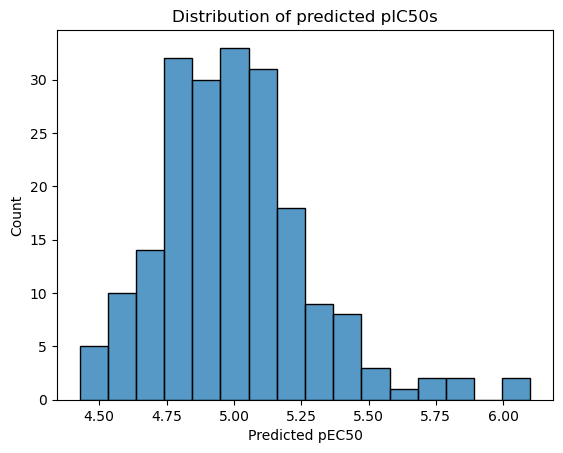

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("predictions.csv").sort_values("OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50")

plt.figure()
sns.histplot(data=df, x='OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50')
plt.xlabel("Predicted pEC50")
plt.title("Distribution of predicted pIC50s")

Because we are using an ensemble model for predictions, we can also visualize the uncertainty of our predictions by adding error bars.

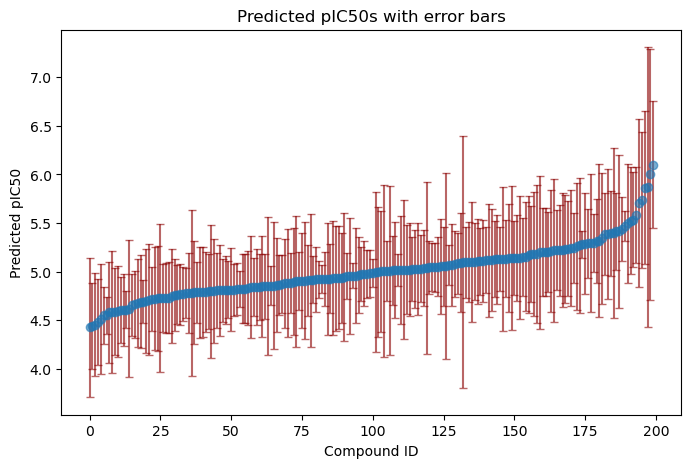

In [11]:
plt.figure(figsize=(8,5))
plt.errorbar(
    y=df['OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50'],
    x=np.arange(len(df)),
    yerr=df['OADMET_STD_openadmet-chembl_OPENADMET_LOGAC50'],
    fmt='o',
    ecolor='darkred',
    alpha=0.6,
    capsize=3
)
plt.ylabel("Predicted pIC50")
plt.xlabel("Compound ID")
plt.title("Predicted pIC50s with error bars")
plt.show()

For this CYP3A4 example, let's focus on the point highlighted in the green rectangle.

<div>
<img src="static/pIC50_annotated.png" alt="ANOVA" width="500"/>.    
</div>

The compound with a predicted pIC50 = 6.0 will have an inhibitory effect on CYP3A4 at a concentration of 1 $\mu M$. However, given the uncertainty estimation we have from our ensemble model, the predicted interval actually spans pIC50 of approximately 4.5 - 7.1. In other words, it's likely that the actual pIC50 of this compound falls anywhere within the 4.5 - 7.1 pIC50 range, or the 10 mM - 10 $\mu M$ range. Thats 3 log units or almost 3 orders of magnitude! Our model is not very sure about this compound at all. This is why it is so important to try predict the error in your model alongside predicted activity and to make sure that uncertainty is as accurate as possible.

Depending on your specific use-case, this compound and the other high activity compounds may still be worth examining more closely. The molecular structures are displayed from most active to least active below. A molecule with a CYP3A4 pIC50 of 6 (IC50 of 1 uM)like we are seeing at the top range here is unlikely to do well in further development (if real).

In [10]:
import mols2grid

df_sorted = df.sort_values('OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50', ascending=False)
mols2grid.display(df_sorted, smiles_col="OPENADMET_CANONICAL_SMILES")

MolGridWidget()

## We  don't have enough data!

OpenADMET is aiming to collect a lot more of this data! This will allow us to test the generalizability of our current models and build better models going forward!


~ End of `05_Model_Ensemble_Inference` ~